In [36]:
%matplotlib inline
import sys
!{sys.executable} -m pip install pendulum
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt
import pendulum 

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# Reflect Database into ORM classes
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Measurements
Measurement = Base.classes.measurement
# Stations
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
# caculating TMIN, TAVE, TMAX FOR  2016-06-06 to 2017-06-06
tmin, tave, tmax = calc_temps('2017-06-06', '2017-06-09')[0]
print(tmin, tave, tmax)

72.0 77.66666666666667 81.0


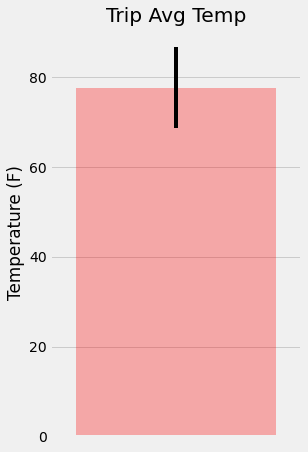

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = tmax-tmin

plt.figure(figsize=(4,7))
plt.bar(1,tave, yerr= error, color='red', alpha=0.3)
# Plot properties
plt.xlim(0.5,1.5)
plt.gca().xaxis.grid(False)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) # getting rid of x labels and xticks

#setting labels
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
# saving image 
plt.savefig("./Output_Data/trip_avg_temp_error.png")

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_dates = ['2017-08-14','2017-08-21']

parms = [Station.station,Station.name, Station.latitude, Station.longitude,Station.elevation, func.sum(Measurement.prcp)]

query = session.query(*parms).group_by(Station.station).\
filter(Station.station == Measurement.station).\
filter(Measurement.date>=trip_dates[0]).filter(Measurement.date<=trip_dates[1]).order_by(func.sum(Measurement.prcp).desc()).statement

rainfall_stations = pd.read_sql_query(query, session.bind)
rainfall_stations.rename(columns={"sum_1": "total amount of rainfall"}, inplace=True)
rainfall_stations

,station,name,latitude,longitude,elevation,total amount of rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.84
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.51
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.26
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.04
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]

# For example
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
dates = []
normals = []
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

init_date = pendulum.parse(start_date)  # creating a DataTime object type using pendulum module and formatting like YYYY-MM_DD
end_date = pendulum.parse(end_date)  # creating a DataTime object type using pendulum module and formatting like YYYY-MM_DD
period = init_date.diff(end_date) # calculates a period of time between init_date and end_date

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d

for day in range(period.in_days()+1):
    temp_date = end_date.subtract(days=day)
    dates.append(temp_date.format("MM-DD")) #formatting date so we only return month and day
    
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = list(map(daily_normals, dates))
normals

[(71.0, 77.15686274509804, 83.0),
 (67.0, 76.25, 83.0),
 (69.0, 76.14814814814815, 82.0),
 (69.0, 76.71153846153847, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (68.0, 75.60377358490567, 84.0),
 (67.0, 75.54, 83.0)]

In [53]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_history = pd.DataFrame(normals, columns=['Temp_Min','Temp_Avg','Temp_Max'])
trip_history.set_index(pd.Series(dates, name='date'),inplace=True) # setting index using a pandas.series containing our trip's dates
trip_history

,Temp_Min,Temp_Avg,Temp_Max
date,,,
08-07,71.0,77.156863,83.0
08-06,67.0,76.250000,83.0
08-05,69.0,76.148148,82.0
08-04,69.0,76.711538,84.0
08-03,70.0,76.611111,85.0
08-02,68.0,75.603774,84.0
08-01,67.0,75.540000,83.0


Text(0.5, 0, 'Date')

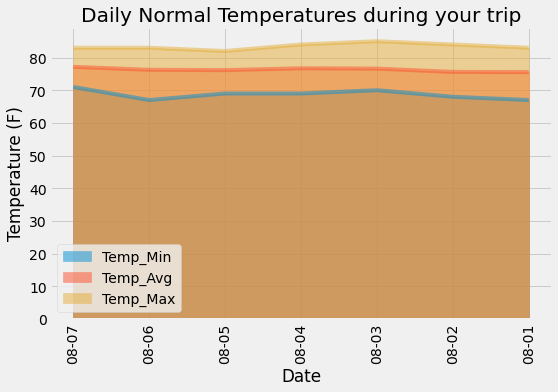

In [70]:
# Plot the daily normals as an area plot with `stacked=False`
trip_history.plot.area(stacked=False, figsize=(8,5))
plt.title("Daily Normal Temperatures during your trip")
plt.xticks(rotation=90)
plt.ylabel("Temperature (F)")
plt.xlabel("Date")


## Close Session

In [ ]:
session.close()